# cMetrics Visualizer
Choose any number of containers ($n$) and any number of stats ($m$) that you want to see. The visualizer will display $m$ plots  with $n$ lines each, represeting your choice. Use `SHIFT` or `CMD` to select multiple items, then press `GET GRAPHS`.

Run All to begin.

Ignore the Widget Javascript warning.


In [1]:
from IPython.display import HTML
from __future__ import print_function

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib import style
import redis
from datetime import datetime
import ipywidgets as widgets
import json
import os
import sys
import time
import numpy as np
from IPython.display import display

HOST = "127.0.0.1"
PORT = 6379
LIMIT = 20
stat_names = {"Time": "timestamp", "CPU_Load": "cpu_load", "CPU Usage": "cpu_usage", "RX Bytes": "network_rx", "TX Bytes": "network_tx", "Memory Usage": "memory", "Read KB": "disk_read", "Write KB": "disk_write"}
inv_stat_names = {v: k for k, v in stat_names.items()}
style.use("ggplot")
r = redis.StrictRedis(host=HOST, port=PORT)

In [3]:
def append(arr, item):
    if len(arr) >= LIMIT:
        arr.pop(0)
    arr.append(item)

def cycle(i):
    color = "brgcmykw"
    if i  == 8:
        i = -1
    i += 1
    return color[i], i

def updateEach(name, jsn):
    if len(name["timestamp"]) > 0 and jsn["ts"] == name["timestamp"][-1].strftime("%X"):
        return
    append(name["cpu_load"], jsn["cpu"]["load"]["ave"])
    append(name["cpu_usage"], jsn["cpu"]["usage"])
    append(name["network_rx"], jsn["network"]["rx_kb"])
    append(name["network_tx"], jsn["network"]["tx_kb"])
    append(name["memory"], jsn["memory"]["ave"])
    append(name["disk_read"], jsn["diskio"]["read"])
    append(name["disk_write"], jsn["diskio"]["write"])
    append(name["timestamp"], datetime.strptime(jsn["ts"], "%X"))

def plotme(containers, stats):
    entries = {}
    figs = {}
    colormap = plt.cm.Accent
        
    for name in containers:
        entries[name] = {}
        last20 = r.lrange(name, 0, 19)[::-1]
        for s in stat_names.values():
            entries[name][s] = []
        for e in last20:
            updateEach(entries[name], json.loads(e))
    for stat in stats:
        stat_title = inv_stat_names[stat]
        f = plt.figure(num=stat_title, figsize=(9, 5))
        ax = f.add_subplot(1,1,1)
        colors = "rgb"
        i = 0
        for name in containers:
            color, i = cycle(i)
            ax.plot(entries[name]["timestamp"], entries[name][stat], color=color, label=name)    
        stat_title = inv_stat_names[stat]
        ax.set_xlabel("Time")
        ax.set_ylabel(stat_title)
        box = ax.get_position()
        ax.legend(ncol=2, loc='upper center', bbox_to_anchor=[0.5, 1.1])        
        figs[stat] = [f,ax]

    def animate():
        for name in containers:
            updateEach(entries[name], json.loads(r.lindex(name, 0)))            
        for stat in stats:
            f  = figs[stat][0]
            ax = figs[stat][1]
            ax.clear()
            i = 0
            for name in containers:
                color, i = cycle(i)
                ax.plot(entries[name]["timestamp"], entries[name][stat], color=color, label=name)   
            ax.set_xlabel("Time")
            ax.legend(ncol=2, loc='upper center', bbox_to_anchor=[0.5, 1.1])        
            f.canvas.draw()

    while True:
        animate()
        time.sleep(1)

Widget Javascript not detected.  It may not be installed or enabled properly.


<IPython.core.display.Javascript object>


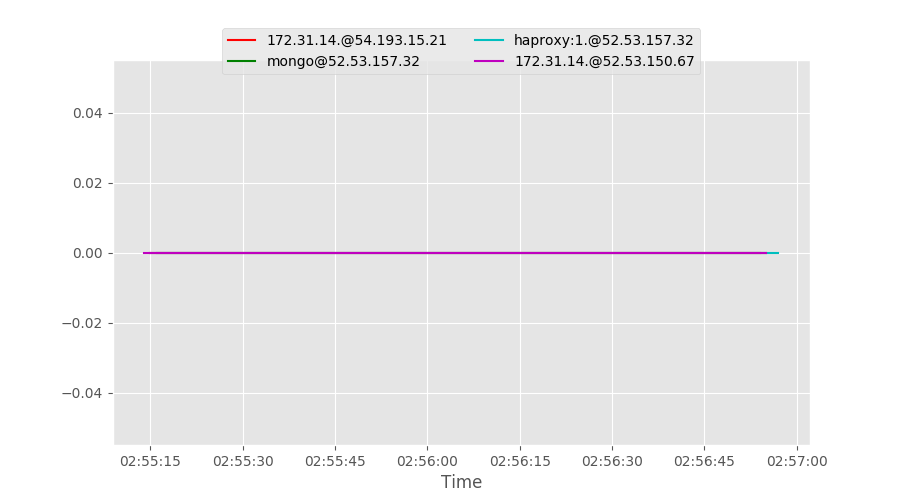

<IPython.core.display.Javascript object>


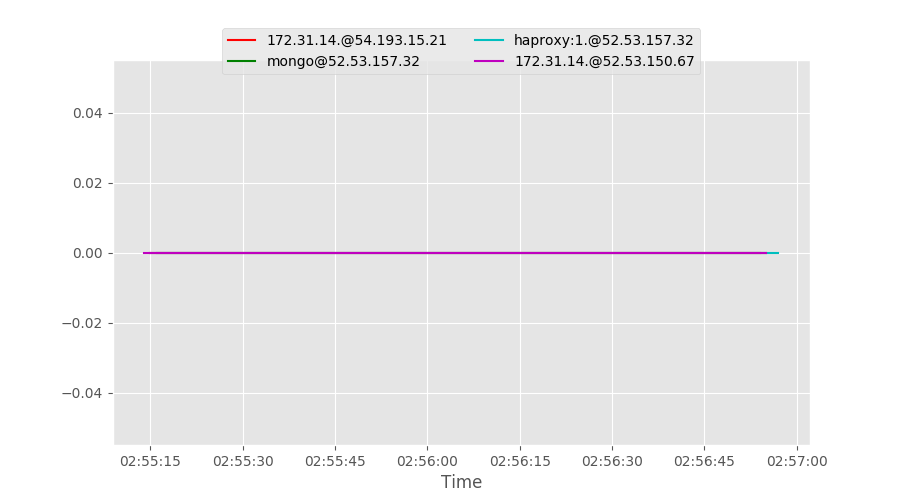

<IPython.core.display.Javascript object>


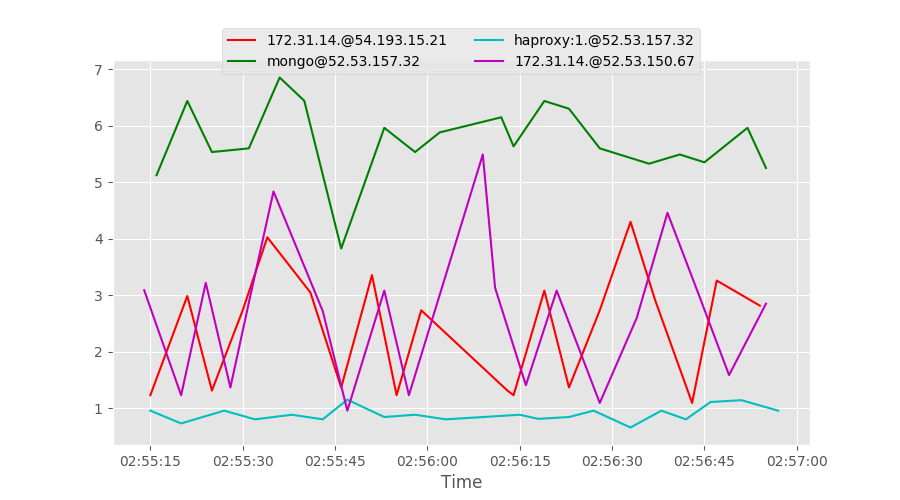

<IPython.core.display.Javascript object>


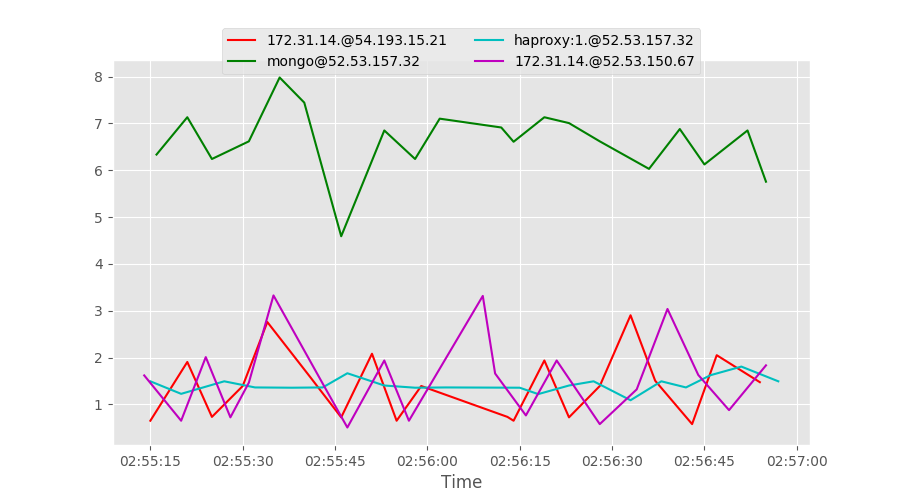

ConnectionError: Error 61 connecting to 127.0.0.1:6379. Connection refused.

In [4]:
all_containers = [x.decode('utf-8') for x in list(r.smembers("names"))]

cont1 = widgets.SelectMultiple(
    options=all_containers,
    layout=widgets.Layout(display="flex", flex_flow='column'),
    description='Choose Containers',
    disabled=False
)

cont2 = widgets.SelectMultiple(
    options=stat_names,
    layout=widgets.Layout(display="flex", flex_flow='column'),
    description='Choose Containers',
    disabled=False
)



submit = widgets.Button(
    description='Get Graphs',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Get Graphs',
    icon='check'
)

boc = widgets.HBox([cont1, cont2, submit])
display(boc)
names = []
stats = []


def on_button_clicked(b):
    del names[:]
    del stats[:]
    names.extend(list(cont1.value))
    stats.extend(list(cont2.value))
    plotme(names, stats)

submit.on_click(on_button_clicked)
